# Boosting in Cox Regression

## Load libraries

In [1]:
## load the required packages

# clear all workspace
rm(list=ls()) 
# install the necessary packages
library("mlr3")
library("mlr3proba")
library("mlr3learners")
library("mlr3extralearners")
library("data.table")
library("mlr3viz")
library("mlr3tuning")
library("mlr3pipelines")
library("purrr")
library("mboost")
library("CoxBoost")
library("survival")
library("paradox")
library("ggrepel")
library("precrec")
library("ggplot2")
library("ggpubr")
library("tidyverse")
library("mlr3filters")
library("ranger")


Attaching package: ‘mlr3extralearners’


The following object is masked from ‘package:mlr3learners’:

    LearnerClassifNnet


The following objects are masked from ‘package:mlr3’:

    lrn, lrns


Loading required package: paradox


Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: parallel

Loading required package: stabs

Loading required package: survival

Loading required package: Matrix

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:mboost’:

    %+%


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()     masks mboost::%+%()
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks M

## Create the task for d4

In [2]:
# read in the raw data
train_data_original <- readRDS("~/Prediction_Challenge_T2E_ML/Data-20210107/train_data.Rds")

In [3]:
# get the corresponding dataframe1
train_data_d4 <- train_data_original$d4

In [4]:
## create the corresponding task as for dataframe 1
tsks_train_d4 <- TaskSurv$new("df4", backend = train_data_original$d4, time = "time", event = "status")
## check the task
tsks_train_d4

<TaskSurv:df4> (698 x 9)
* Target: time, status
* Properties: -
* Features (7):
  - fct (5): V3, V4, V5, V6, V7
  - int (2): V1, V2

## Hyperparameter Tuning for `d4`


In [5]:
## load the learner for the aft boosting and design the benchmark
## Step 1_1: Try with a default setting
design <- benchmark_grid(
  tasks = tsks_train_d4,
  learners = lrn("surv.mboost", baselearner = "bols", family = "weibull"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
aft_bmr <- run_benchmark(design)

INFO  [22:24:44.291] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [22:24:44.440] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 2/3) 
INFO  [22:24:45.144] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 3/3) 
INFO  [22:24:45.748] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 1/3) 
INFO  [22:24:46.384] [mlr3]  Finished benchmark 


In [6]:
# set the global evaluation metric
all_measures <- msr("surv.cindex")

# evaluate the performance with the IBS score
aft_results <- aft_bmr$aggregate(measures = all_measures)
aft_results # 0.8338

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x564006a015a8>,df4,surv.mboost,cv,3,0.6255603


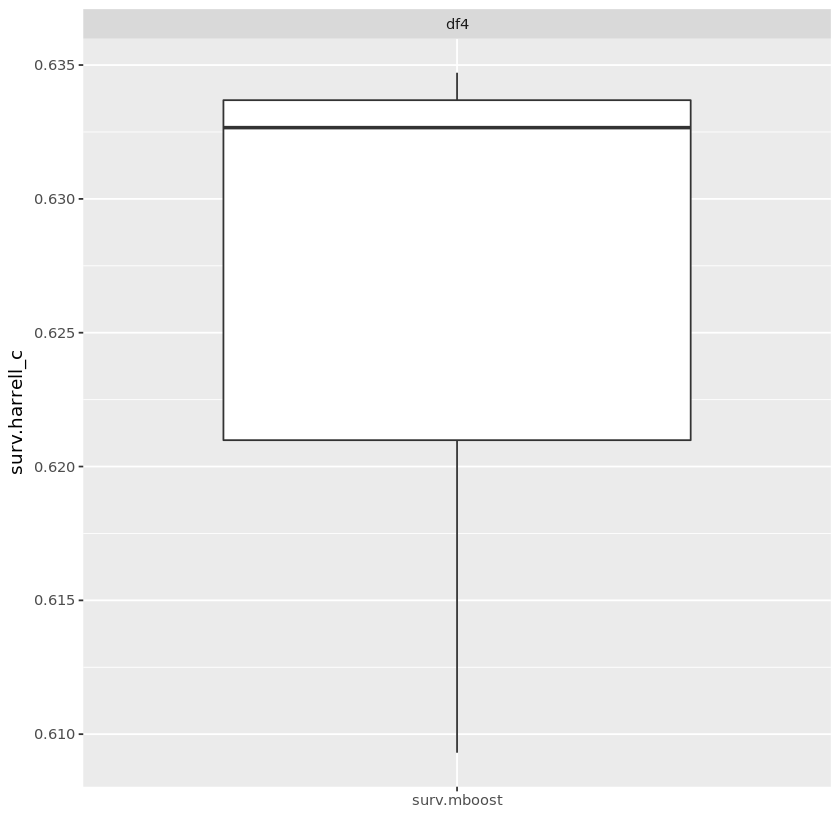

In [7]:
# plot the benchmark result with a default setting
autoplot(aft_bmr)

Step 1_2: Fine_tuning

In [14]:
# load the learner with aft
lrn_aft <- lrn("surv.mboost", baselearner = 'bols', family = "weibull")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("weibull", "loglog", "lognormal")

# set the search space
param_aft_bl <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 100, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_aft <- AutoTuner$new(
  learner = lrn_aft, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_aft_bl,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
aft_bmr_2 = resample(tsks_train_d4, grid_auto_aft, outer_rsmp, store_models = TRUE)

INFO  [22:39:11.812] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df4' (iter 2/3) 
INFO  [22:39:11.851] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [22:39:11.856] [bbotk] Evaluating 1 configuration(s) 
INFO  [22:39:11.886] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [22:39:11.896] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 3/3) 
INFO  [22:39:14.987] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 1/3) 
INFO  [22:39:18.124] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 2/3) 
INFO  [22:39:21.542] [mlr3]  Finished benchmark 
INFO  [22:39:21.592] [bbotk] Result of batch 1: 
INFO  [22:39:21.595] [bbotk]  baselearner family mstop  nu surv.harrell_c 
INFO  [22:39:21.595] [bbotk]        btree loglog   200 0.5      0.5962326 
INFO  [22:39:21.595] [bbotk]                                 uhash 
INFO  [22:39:21.595] [bbotk]  e12766da-2887-4a20-a8d0-a150ef7c87ff 
INFO 

In [15]:
# evaluate the performance
aft_bmr_2$aggregate(measures = msr("surv.cindex")) # 0.626

surv.harrell_c 
     0.6261085

In [16]:
## optimal hyperparameters found by grid search
aft_bmr_2$learners[[2]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "lognormal"

[[1]]$baselearner
[1] "btree"

[[1]]$mstop
[1] 100

[[1]]$nu
[1] 0.1625

Step_1_3: Autoplot the pre and after results

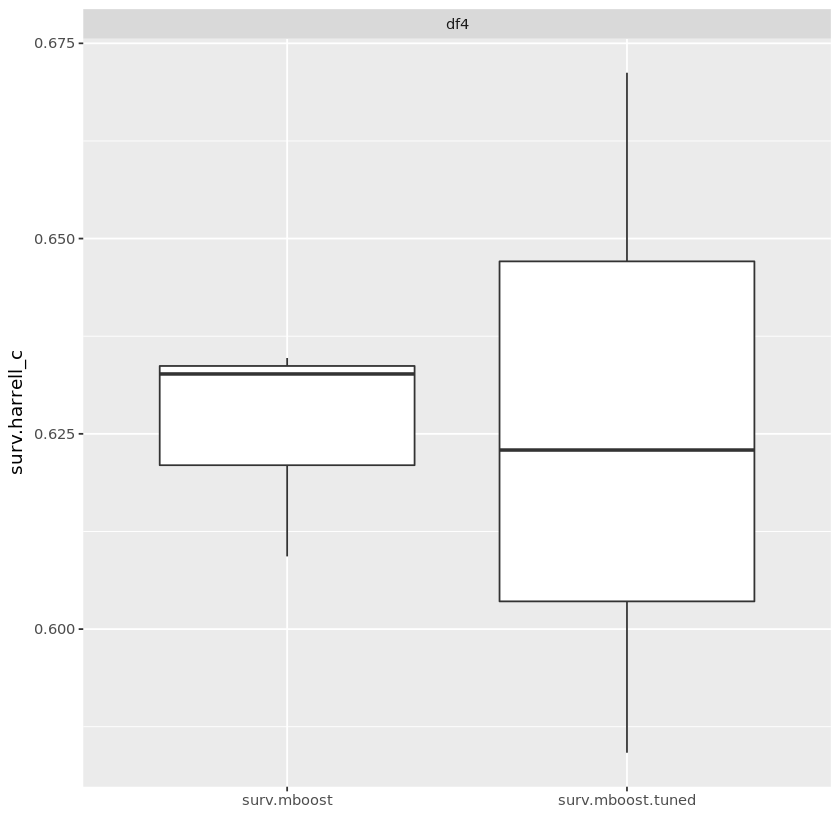

In [17]:
# autoplot the two boxplots
autoplot(c(aft_bmr, aft_bmr_2))

#### Step 2: mboost
Step 2_1: Try with a default setting

In [18]:
design <- benchmark_grid(
  tasks = tsks_train_d4,
  learners = lrn("surv.mboost", baselearner = 'bols', family = "coxph"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
mb_bmr <- run_benchmark(design)

INFO  [22:45:29.395] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [22:45:29.403] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 2/3) 
INFO  [22:45:33.915] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 3/3) 
INFO  [22:45:38.939] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 1/3) 
INFO  [22:45:44.322] [mlr3]  Finished benchmark 


In [19]:
mb_bmr_results <- mb_bmr$aggregate(msr("surv.cindex"))
mb_bmr_results # 0.6344

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x56400ae8ef30>,df4,surv.mboost,cv,3,0.6344687


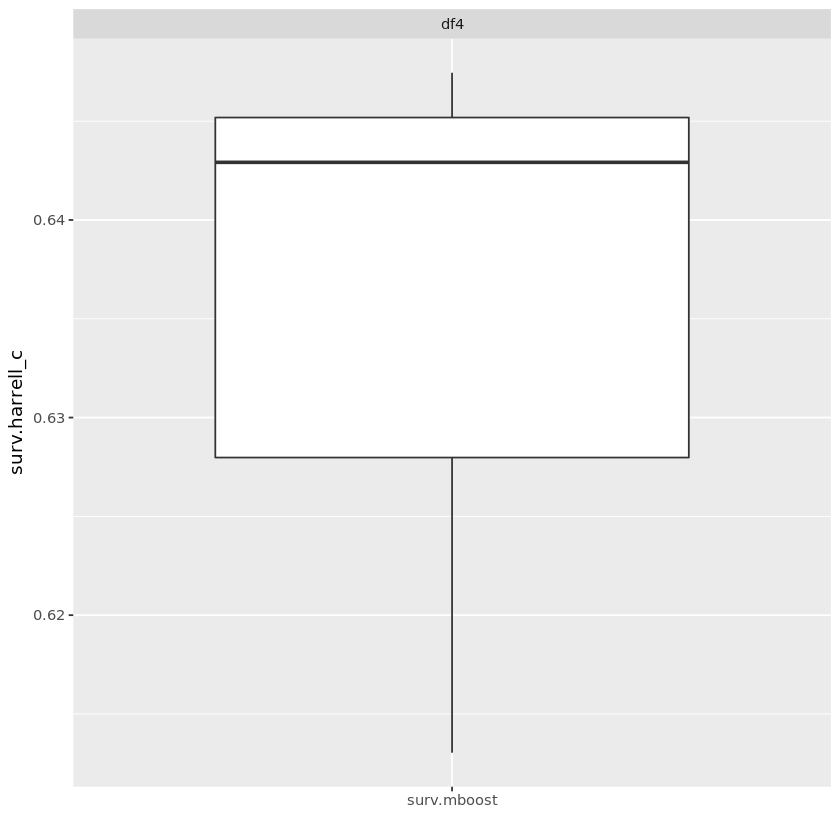

In [20]:
# plot the boxplots
autoplot(mb_bmr)

Step 2_2: Fine_tuning

In [23]:
# load the learner with mboost
lrn_mb <- lrn("surv.mboost", baselearner = 'bols', family = "coxph")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("cindex", "coxph")

# set the search space
param_mb <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 100, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_mb <- AutoTuner$new(
  learner = lrn_mb, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_mb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
mb_bmr_2 = resample(tsks_train_d4, grid_auto_mb, outer_rsmp, store_models = TRUE)

INFO  [23:01:05.755] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df4' (iter 1/3) 
INFO  [23:01:05.791] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [23:01:05.795] [bbotk] Evaluating 1 configuration(s) 
INFO  [23:01:05.822] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [23:01:05.831] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 3/3) 
INFO  [23:01:16.723] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 1/3) 
INFO  [23:01:27.472] [mlr3]  Applying learner 'surv.mboost' on task 'df4' (iter 2/3) 
INFO  [23:01:38.241] [mlr3]  Finished benchmark 
INFO  [23:01:38.288] [bbotk] Result of batch 1: 
INFO  [23:01:38.291] [bbotk]  baselearner family mstop  nu surv.harrell_c 
INFO  [23:01:38.291] [bbotk]        btree cindex   300 0.5      0.6387466 
INFO  [23:01:38.291] [bbotk]                                 uhash 
INFO  [23:01:38.291] [bbotk]  8b8d6e96-7e81-4d9b-bde8-fd21336ee7d1 
INFO 

In [24]:
# evaluate the performance
mb_bmr_2$aggregate() # 0.618

surv.harrell_c 
      0.618261

In [25]:
## optimal hyperparameters found by grid search
mb_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "cindex"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 100

[[1]]$nu
[1] 0.5

Step_1_3: boxplot the pre and after

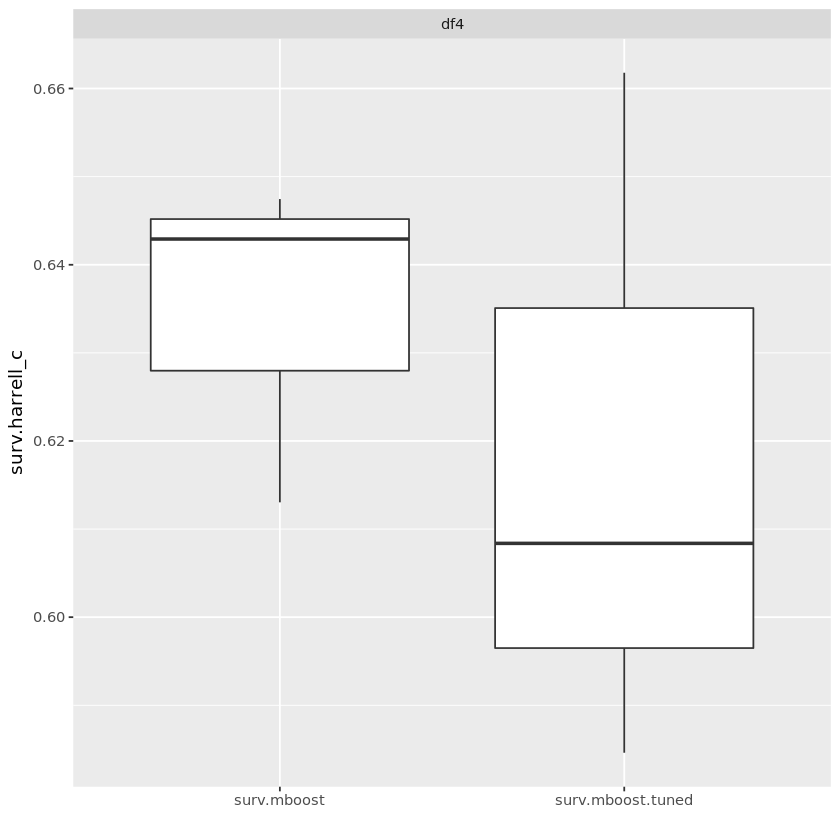

In [26]:
# autoplot the two boxplots
autoplot(c(mb_bmr, mb_bmr_2))

#### Step 3: CoxBoost
Step 3_1: Data Preprocessing to encode the nominal variables

In [28]:
tsks_train_d4 # check the task

<TaskSurv:df4> (698 x 9)
* Target: time, status
* Properties: -
* Features (7):
  - fct (5): V3, V4, V5, V6, V7
  - int (2): V1, V2

In [27]:
library("dataPreparation")
# Compute encoding
train_onehot_d4 <- train_data_d4
encoding <- build_encoding(train_onehot_d4, cols = c("V3","V4","V5","V6","V7"), verbose = TRUE)
# Apply one hot encoding
train_onehot_d4 <- one_hot_encoder(train_onehot_d4, encoding = encoding, drop = TRUE)
str(train_onehot_d4)

## create the corresponding task as for dataframe 1 after one-hot-encoding
tsks_oh_d4 <- TaskSurv$new("df4", backend = train_onehot_d4, time = "time", event = "status")
tsks_oh_d4

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: progress

dataPreparation 1.0.1

Type data_preparation_news() to see new features/changes/bug fixes.



[1] "build_encoding: I will compute encoding on 5 character and factor columns."
[1] "build_encoding: it took me: 0s to compute encoding for 5 character and factor columns."
[1] "one_hot_encoder: I will one hot encode some columns."
[1] "one_hot_encoder: I am doing column: V3"
[1] "one_hot_encoder: I am doing column: V4"
[1] "one_hot_encoder: I am doing column: V5"
[1] "one_hot_encoder: I am doing column: V6"
[1] "one_hot_encoder: I am doing column: V7"
[1] "one_hot_encoder: It took me 0s to transform 5 column(s)."
Classes ‘data.table’ and 'data.frame':	698 obs. of  14 variables:
 $ time     : num  1192 308 33 397 1219 ...
 $ status   : int  0 1 1 1 0 0 0 0 0 1 ...
 $ V1       : int  2 2 2 2 2 2 2 3 2 2 ...
 $ V2       : int  52 74 57 30 66 67 82 45 29 39 ...
 $ V3.male  : int  1 0 1 0 0 1 0 1 1 1 ...
 $ V3.female: int  0 1 0 1 1 0 1 0 0 0 ...
 $ V4.no    : int  1 0 0 0 0 0 1 0 1 0 ...
 $ V4.yes   : int  0 1 1 1 1 1 0 1 0 1 ...
 $ V5.no    : int  0 1 0 1 1 1 1 0 0 1 ...
 $ V5.yes   : i

<TaskSurv:df4> (698 x 14)
* Target: time, status
* Properties: -
* Features (12):
  - int (12): V1, V2, V3.female, V3.male, V4.no, V4.yes, V5.no, V5.yes,
    V6.no, V6.yes, V7.no, V7.yes

Step 3_2: Try with a default setting

In [29]:
library("pracma")


Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu


The following object is masked from ‘package:purrr’:

    cross




In [30]:
install_learners('surv.coxboost')

In [31]:
design <- benchmark_grid(
  tasks = tsks_oh_d4,
  learners = lrn("surv.coxboost", criterion="hpscore"),
  resampling = rsmp("cv", folds = 3L)
)

# lrn("surv.coxboost")$param_set

# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
cb_bmr <- run_benchmark(design)


# set the global evaluation metric
all_measures <- msr("surv.cindex")

cb_results <- cb_bmr$aggregate(measures = all_measures)
cb_results # 0.625

INFO  [23:19:45.624] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [23:19:45.715] [mlr3]  Applying learner 'surv.coxboost' on task 'df4' (iter 2/3) 
INFO  [23:19:54.310] [mlr3]  Applying learner 'surv.coxboost' on task 'df4' (iter 3/3) 
INFO  [23:20:03.139] [mlr3]  Applying learner 'surv.coxboost' on task 'df4' (iter 1/3) 
INFO  [23:20:12.683] [mlr3]  Finished benchmark 


nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x564054d87c48>,df4,surv.coxboost,cv,3,0.6253477


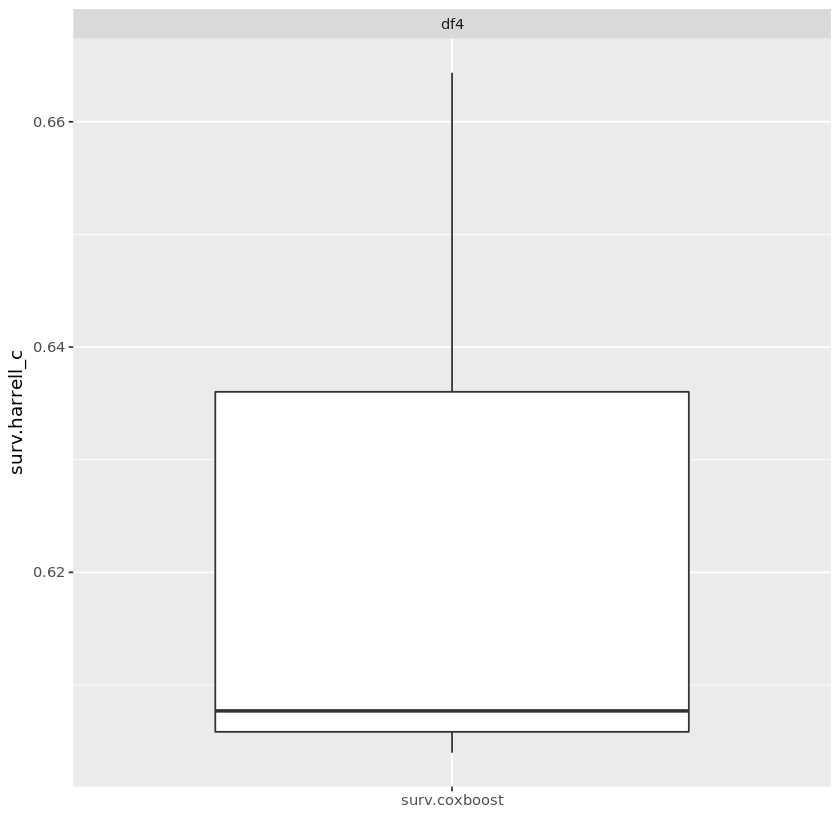

In [32]:
# plot the corresponding the performance
autoplot(cb_bmr)

Step_3_3: Fine-tuning with CoxBoost

In [33]:
# load the learner with CoxBoost
lrn_cb <- lrn("surv.coxboost", criterion="hpscore")
# from 50-250, 100-300, 150-250

# set the search space
param_cb <- ParamSet$new(params = list(
  ParamInt$new("stepno", lower = 50, upper = 300),
  ParamDbl$new("penalty", lower = 100, upper = 500),
  ParamDbl$new("stepsize.factor", lower = 0.1, upper = 10)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_cb <- AutoTuner$new(
  learner = lrn_cb, resampling =  inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_cb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)

cb_bmr_2 = resample(tsks_oh_d4, grid_auto_cb, outer_rsmp, store_models = TRUE)

INFO  [23:20:37.734] [mlr3]  Applying learner 'surv.coxboost.tuned' on task 'df4' (iter 1/3) 
INFO  [23:20:37.812] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [23:20:37.816] [bbotk] Evaluating 1 configuration(s) 
INFO  [23:20:37.842] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [23:20:37.851] [mlr3]  Applying learner 'surv.coxboost' on task 'df4' (iter 1/3) 
INFO  [23:20:42.649] [mlr3]  Applying learner 'surv.coxboost' on task 'df4' (iter 2/3) 
INFO  [23:20:47.350] [mlr3]  Applying learner 'surv.coxboost' on task 'df4' (iter 3/3) 
INFO  [23:20:51.976] [mlr3]  Finished benchmark 
INFO  [23:20:52.022] [bbotk] Result of batch 1: 
INFO  [23:20:52.025] [bbotk]  stepno penalty stepsize.factor surv.harrell_c 
INFO  [23:20:52.025] [bbotk]     175     400            5.05      0.5687942 
INFO  [23:20:52.025] [bbotk]                                 uhash 
INFO  [23:20:52.025] [bbotk]  b8385b90-8d78-4a05-9614-dada4de

In [34]:
# evaluate the performance
cb_bmr_2$aggregate() # 0.616

surv.harrell_c 
     0.6163158

In [35]:
## optimal hyperparameters found by grid search
cb_bmr_2$learners[[1]]$tuning_result$learner_param_vals	

[[1]]
[[1]]$criterion
[1] "hpscore"

[[1]]$stepno
[1] 112

[[1]]$penalty
[1] 400

[[1]]$stepsize.factor
[1] 0.1

Step_3_4: Autoplot the pre and after tuning boxplots

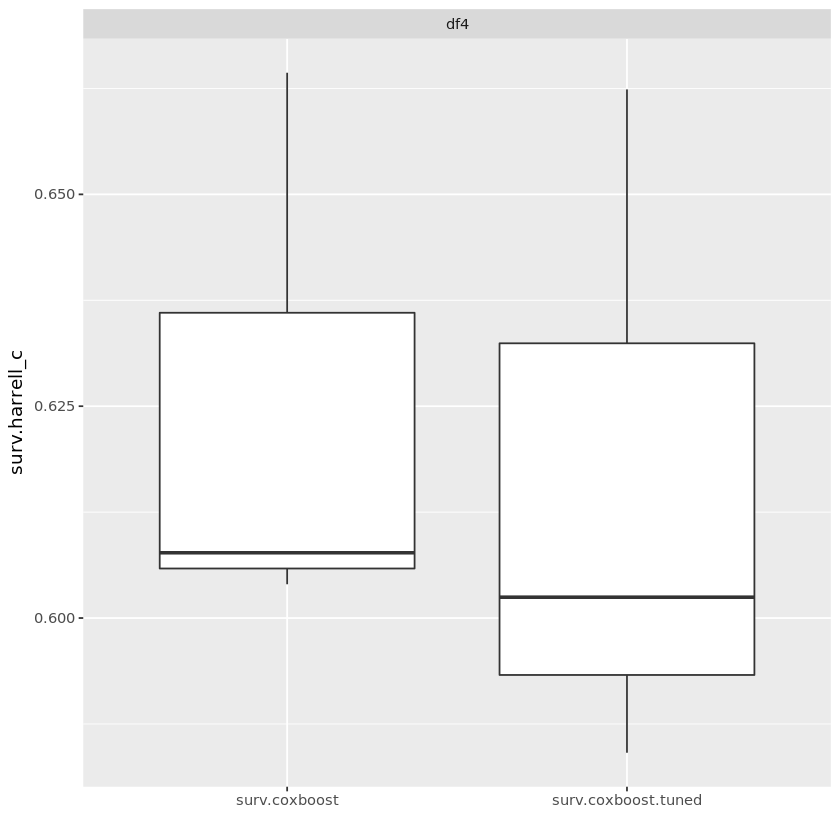

In [36]:
# autoplot the two boxplots
autoplot(c(cb_bmr, cb_bmr_2))